<a href="https://colab.research.google.com/github/riddhi-2080/Kaggle-Assignment/blob/master/ImageRec02_Transfer_Learning_v2_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Import Libraries and Dependencies

In [ ]:
import scipy as sp
import numpy as np
import pandas as pd
from numpy.random import rand
pd.options.display.max_colwidth = 600

# Scikit Imports
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.model_selection import train_test_split

import cnn_utils as utils
from model_evaluation_utils import get_metrics

# Matplot Imports
import matplotlib.pyplot as plt
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}

plt.rcParams.update(params)
%matplotlib inline

# pandas display data frames as tables
from IPython.display import display, HTML

import warnings
warnings.filterwarnings('ignore')

from google.colab import files
uploaded = files.upload()

!ls -ltr


In [ ]:
import tensorflow as tf
from keras import callbacks
from keras import optimizers
from keras.datasets import cifar10
from keras.engine import Model
from keras.applications import vgg16 as vgg
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D,BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils

Using TensorFlow backend.


#### Initiate 

In [ ]:
BATCH_SIZE = 32
EPOCHS = 50
NUM_CLASSES = 10
LEARNING_RATE = 1e-4
MOMENTUM = 0.9

#### Data Read & Train-Test Split


In [ ]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train, 
                                                  test_size=0.15, 
                                                  stratify=np.array(y_train), 
                                                  random_state=42)

In [ ]:
Y_train = np_utils.to_categorical(y_train, NUM_CLASSES)
Y_val = np_utils.to_categorical(y_val, NUM_CLASSES)
Y_test = np_utils.to_categorical(y_test, NUM_CLASSES)

#### Base Model


In [ ]:
base_model = vgg.VGG16(weights='imagenet', 
                       include_top=False, 
                       input_shape=(32, 32, 3))

In [ ]:

# Extract the last layer from third block of vgg16 model
last = base_model.get_layer('block3_pool').output

In [ ]:
# Add classification layers on top of it

x = GlobalAveragePooling2D()(last)
x= BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.6)(x)
pred = Dense(NUM_CLASSES, activation='softmax')(x)
model = Model(base_model.input, pred)

In [ ]:
for layer in base_model.layers:
     layer.trainable = False

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=LEARNING_RATE),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0   

#### Data Augmentation


In [ ]:
# prepare data augmentation configuration
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    horizontal_flip=True)

In [ ]:
train_datagen.fit(X_train)
train_generator = train_datagen.flow(X_train,
                                     Y_train, 
                                     batch_size=BATCH_SIZE)

In [ ]:

val_datagen = ImageDataGenerator(rescale=1. / 255,
    horizontal_flip=True)

val_datagen.fit(X_val)
val_generator = val_datagen.flow(X_val,
                                 Y_val,
                                 batch_size=BATCH_SIZE)

In [ ]:
train_steps_per_epoch = X_train.shape[0] //BATCH_SIZE
val_steps_per_epoch = X_val.shape[0] //BATCH_SIZE

history = model.fit_generator(train_generator,
                              steps_per_epoch=train_steps_per_epoch,
                              validation_data=val_generator,
                              validation_steps=val_steps_per_epoch,
                              epochs=EPOCHS,
                              verbose=1)

Epoch 1/50
1328/1328 [==============================] - 13s 10ms/step - loss: 1.6851 - accuracy: 0.4088 - val_loss: 1.2198 - val_accuracy: 0.5921
Epoch 2/50
1328/1328 [==============================] - 11s 8ms/step - loss: 1.2793 - accuracy: 0.5535 - val_loss: 1.0729 - val_accuracy: 0.6359
Epoch 3/50
1328/1328 [==============================] - 10s 8ms/step - loss: 1.1488 - accuracy: 0.5995 - val_loss: 0.8062 - val_accuracy: 0.6648
Epoch 4/50
1328/1328 [==============================] - 10s 8ms/step - loss: 1.0772 - accuracy: 0.6243 - val_loss: 0.8301 - val_accuracy: 0.6855
Epoch 5/50
1328/1328 [==============================] - 10s 8ms/step - loss: 1.0228 - accuracy: 0.6440 - val_loss: 1.0364 - val_accuracy: 0.6955
Epoch 6/50
1328/1328 [==============================] - 10s 8ms/step - loss: 0.9863 - accuracy: 0.6561 - val_loss: 0.8001 - val_accuracy: 0.6998
Epoch 7/50
1328/1328 [==============================] - 10s 8ms/step - loss: 0.9536 - accuracy: 0.6675 - val_loss: 0.9042 - val_a

#### Visualize the Accuracy & Loss

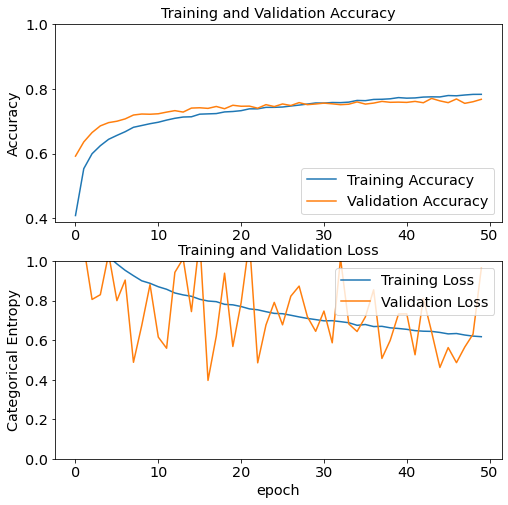

In [ ]:
acc = model.history.history['accuracy']
val_acc = model.history.history['val_accuracy']

loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Categorical Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
predictions = model.predict(X_test/255.)

In [ ]:
test_labels = list(y_test.squeeze())
predictions = list(predictions.argmax(axis=1))

In [ ]:
get_metrics(true_labels=y_test, 
                predicted_labels=predictions)

Accuracy: 0.7603
Precision: 0.7607
Recall: 0.7603
F1 Score: 0.7599


In [ ]:
label_dict = {0:'airplane',
             1:'automobile',
             2:'bird',
             3:'cat',
             4:'deer',
             5:'dog',
             6:'frog',
             7:'horse',
             8:'ship',
             9:'truck'}

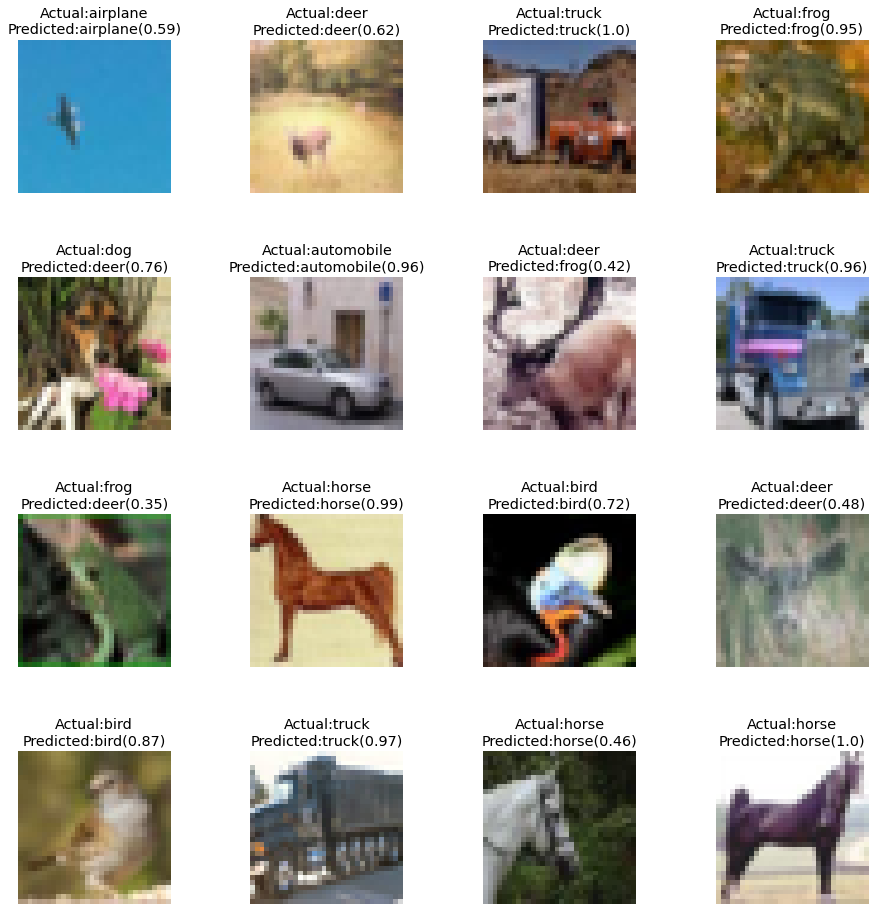

In [ ]:
utils.plot_predictions(model=model,dataset=X_test/255.,
                       dataset_labels=Y_test,
                       label_dict=label_dict,
                       batch_size=16,
                       grid_height=4,
                       grid_width=4)